In [2]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
%run imports.ipynb

In [4]:
chromosomes = ['chr' + str(i) for i in range(1, 20)] + ['chrX', 'chrY']

In [5]:
ad_called_files = ['/data/project/JBK_AdipoMeth/result/DMR/G_DNA-3T3L1-AD/called/' + c + '.patterns' for c in chromosomes]

In [6]:
pre_called_files = ['/data/project/JBK_AdipoMeth/result/DMR/G_DNA-3T3L1-pre/called/' + c + '.patterns' for c in chromosomes]

In [7]:
ad_meth_file = '/data/project/JBK_AdipoMeth/result/WGBS/G_DNA-3T3L1-AD/G_DNA-3T3L1-AD.bismark.deduplicated.sorted_CpG.meth.bedGraph'
pre_meth_file = '/data/project/JBK_AdipoMeth/result/WGBS/G_DNA-3T3L1-pre/G_DNA-3T3L1-pre.bismark.deduplicated.sorted_CpG.meth.bedGraph'

Methylation 결과 파일 파싱.

In [8]:
ad_meth = pd.read_csv(ad_meth_file, sep='\t', skiprows=1, names=['chrom', 'start', 'end', 'beta'])

In [9]:
ad_meth.head(3)

,chrom,start,end,beta
0,chr1,3000826,3000828,0.211538
1,chr1,3001006,3001008,0.044118
2,chr1,3001017,3001019,0.000000


In [10]:
pre_meth = pd.read_csv(pre_meth_file, sep='\t', skiprows=1, names=['chrom', 'start', 'end', 'beta'])

In [11]:
pre_meth.head(3)

,chrom,start,end,beta
0,chr1,3000826,3000828,0.222222
1,chr1,3001006,3001008,0.066667
2,chr1,3001017,3001019,0.064516


In [408]:
%store ad_meth
%store pre_meth

Stored 'ad_meth' (DataFrame)
Stored 'pre_meth' (DataFrame)


CpG-MPs 결과 파일 파싱.

In [12]:
ad_called = dict()

for file in ad_called_files:
    chrom = os.path.basename(file).split('.')[0]
    ad_called[chrom] = pd.read_csv(file, sep='\t')
    
pre_called = dict()

for file in pre_called_files:
    chrom = os.path.basename(file).split('.')[0]
    pre_called[chrom] = pd.read_csv(file, sep='\t')

총 interval이 몇개지?

In [13]:
sum(len(ad_called[chrom]) for chrom in ad_called)

652357

In [14]:
sum(len(pre_called[chrom]) for chrom in pre_called)

652238

In [17]:
pre_called['chr1'].head(3)

,Chrosome,Start_position,End_position,Methylation_pattern,Length,Average_methylation_level,Variance
0,chr1,3000826,3001628,-1,803,0.115,0.090
1,chr1,3003225,3003897,1,673,0.711,0.139
2,chr1,3004529,3019919,-1,15391,0.119,0.181


In [19]:
pre_called['chr1'].Length.max()

226124

In [230]:
ad_called['chr1'].head(3)

,Chrosome,Start_position,End_position,Methylation_pattern,Length,Average_methylation_level,Variance
0,chr1,3000826,3003378,-1,2553,0.268,0.288
1,chr1,3003581,3003897,1,317,0.747,0.041
2,chr1,3004529,3020944,-1,16416,0.155,0.230


적어도 한 쪽이 -1로 call 된 interval을 순회하면서 average beta 차이가 0.2 이상 나는지 확인한다.

In [231]:
# ad_meth, pre_meth chromosome 별로 subset 만들어 두자.
ad_meth_cache, pre_meth_cache = dict(), dict()
chromosomes = list(ad_called.keys())

for chrom in chromosomes:
    ad_meth_cache[chrom] = ad_meth.loc[ad_meth.chrom == chrom]
    pre_meth_cache[chrom] = pre_meth.loc[pre_meth.chrom == chrom]

In [409]:
# %store ad_meth_cache
# %store pre_meth_cache

Stored 'ad_meth_cache' (dict)
Stored 'pre_meth_cache' (dict)


In [74]:
from tqdm import tqdm_notebook
from dohlee.thread import threaded

In [233]:
def find_dmr(chrom, start, end):
    # chrom:start-end 에 포함된느 CpG들에 대해
    # AD와 Pre 쪽에서 그 beta 값을 각각 확인해서 평균 차이가 0.2 이상 나는지 본다.
    ad_subset = ad_meth_cache[chrom]
    ad_subset = ad_subset.loc[(start <= ad_subset.start) & (ad_subset.end <= end)]
    if len(ad_subset) < 3:
        return None

    pre_subset = pre_meth_cache[chrom]
    pre_subset = pre_subset.loc[(start <= pre_subset.start) & (pre_subset.end <= end)]
    if len(pre_subset) < 3:
        return None

    ad_mean_beta = ad_subset.beta.mean()
    pre_mean_beta = pre_subset.beta.mean()

    if abs(ad_mean_beta - pre_mean_beta) >= 0.2:
        return (chrom, start, end, ad_mean_beta, pre_mean_beta)
    else:
        return None

In [234]:
params = \
[(row.Chrosome, row.Start_position, row.End_position) for df in ad_called.values() for i, row in df.iterrows() if row.Methylation_pattern == -1] +\
[(row.Chrosome, row.Start_position, row.End_position) for df in pre_called.values() for i, row in df.iterrows() if row.Methylation_pattern == -1]

In [235]:
params[:4]

[('chr1', 3000826, 3003378),
 ('chr1', 3004529, 3020944),
 ('chr1', 3021344, 3022041),
 ('chr1', 3022536, 3026412)]

In [236]:
result = list(threaded(
    func=find_dmr,
    params=params,
    processes=72,
    progress=True,
    progress_type='tqdm_notebook',
))

In [237]:
len(result)

649187

In [239]:
dmrs = [x for x in result if x is not None]

In [240]:
len(dmrs)

5229

5229개의 DMR이 찾아졌다.

In [241]:
dmrs = pd.DataFrame(dmrs, columns=['chrom', 'start', 'end', 'AD_mean_beta', 'pre_mean_beta'])

hyper/hypo 따로 bed 파일 만들자.

In [242]:
dmrs.loc[dmrs.AD_mean_beta >= dmrs.pre_mean_beta][['chrom', 'start', 'end']].to_csv('result/dmr/ad_hyper_weak.dmr.bed', sep='\t', index=False, header=False)
dmrs.loc[dmrs.AD_mean_beta < dmrs.pre_mean_beta][['chrom', 'start', 'end']].to_csv('result/dmr/ad_hypo_weak.dmr.bed', sep='\t', index=False, header=False)

## CpG_MPs 에서 call된 DMR 불러오기.

In [116]:
directory = '/data/project/JBK_AdipoMeth/result/DMR/called/DMR/'
dmr_files = [os.path.join(directory, chrom + '.dmr') for chrom in chromosomes]

CpG >= 3 으로 수정하여 다시.

In [243]:
directory = '/data/project/JBK_AdipoMeth/result/DMR/called/DMR/'
dmr_files = [os.path.join(directory, chrom + '.dmr') for chrom in chromosomes]

In [120]:
pd.read_csv(dmr_files[0], sep='\t').head(3)

,Chromosome,Start_position,End_position,Length,Average_methylation_level,V_value,Entropy
0,chr1,14310465,14310715,251,0.521_0.851,1,1.599
1,chr1,36370968,36371148,181,0.164_0.548,1,1.380
2,chr1,36914608,36914822,215,0.134_0.749,1,0.701


In [123]:
dmr_df = pd.concat([pd.read_csv(f, sep='\t') for f in dmr_files])

In [124]:
dmr_df.shape

(1855, 7)

CpG >= 3 버전

In [244]:
dmr_df = pd.concat([pd.read_csv(f, sep='\t') for f in dmr_files])

In [245]:
dmr_df.shape

(3860, 7)

In [129]:
ad_hyper_dmr_mask = [float(t.split('_')[0]) > float(t.split('_')[1]) for t in dmr_df.Average_methylation_level]
ad_hypo_dmr_mask = [float(t.split('_')[0]) < float(t.split('_')[1]) for t in dmr_df.Average_methylation_level]

assert sum(ad_hyper_dmr_mask) + sum(ad_hypo_dmr_mask) == dmr_df.shape[0]

sum(ad_hyper_dmr_mask), sum(ad_hypo_dmr_mask)

CpG >= 3 버전

In [246]:
ad_hyper_dmr_mask = [float(t.split('_')[0]) > float(t.split('_')[1]) for t in dmr_df.Average_methylation_level]
ad_hypo_dmr_mask = [float(t.split('_')[0]) < float(t.split('_')[1]) for t in dmr_df.Average_methylation_level]

assert sum(ad_hyper_dmr_mask) + sum(ad_hypo_dmr_mask) == dmr_df.shape[0]

sum(ad_hyper_dmr_mask), sum(ad_hypo_dmr_mask)

(126, 3734)

In [247]:
# BED 파일로 저장하자.
selected = ['Chromosome', 'Start_position', 'End_position']
dmr_df.loc[ad_hyper_dmr_mask][selected].to_csv('result/dmr/ad_hyper.dmr.bed', sep='\t', index=False, header=False)
dmr_df.loc[ad_hypo_dmr_mask][selected].to_csv('result/dmr/ad_hypo.dmr.bed', sep='\t', index=False, header=False)

In [248]:
!wc -l 'result/dmr/ad_hyper.dmr.bed'

126 result/dmr/ad_hyper.dmr.bed


In [249]:
!wc -l 'result/dmr/ad_hypo.dmr.bed'

3734 result/dmr/ad_hypo.dmr.bed


Methylation 차이의 분포를 한번 보자.

In [25]:
hyper_df = pd.read_csv('result/dmr/ad_hyper.dmr.bed', sep='\t', names=['chrom', 'start', 'end'])
hyper_df['length'] = hyper_df.end - hyper_df.start

hypo_df = pd.read_csv('result/dmr/ad_hypo.dmr.bed', sep='\t', names=['chrom', 'start', 'end'])
hypo_df['length'] = hypo_df.end - hypo_df.start

In [27]:
hyper_df.length.mean()

665.0793650793651

In [250]:
dmr_df.head(3)

,Chromosome,Start_position,End_position,Length,Average_methylation_level,V_value,Entropy
0,chr1,9532262,9532845,584,0.339_0.679,1,1.556
1,chr1,9739588,9739745,158,0.278_0.890,1,0.708
2,chr1,9869276,9869389,114,0.339_0.863,1,0.932


In [251]:
ad_hyper_differences, ad_hypo_differences = [], []
for i, row in dmr_df.iterrows():
    b_ad, b_pre = map(float, row.Average_methylation_level.split('_'))
    if b_ad > b_pre:
        ad_hyper_differences.append(b_ad - b_pre)
    else:
        ad_hypo_differences.append(b_pre - b_ad)

/data/home/dohoon/.env/lab/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


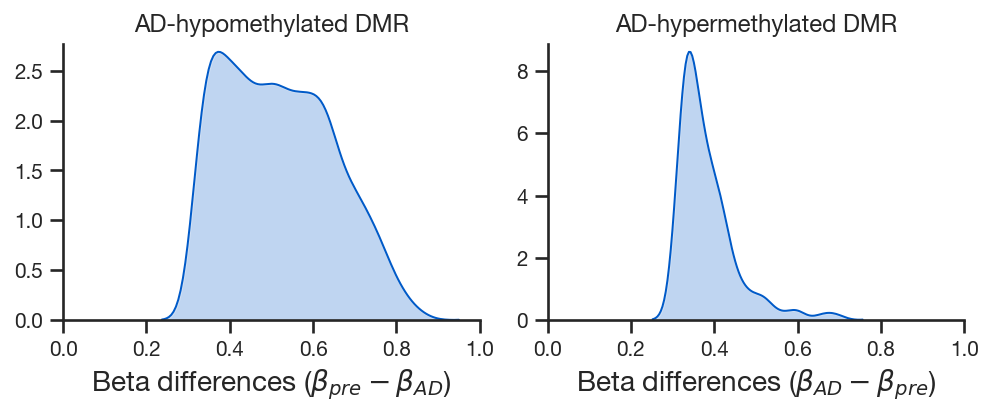

In [410]:
fig = plt.figure(figsize=(7, 3))

ax = fig.add_subplot(121)
sns.kdeplot(ad_hypo_differences, shade=True, ax=ax)
ax.set_xlim([0, 1])
ax.set_xlabel(r'Beta differences ($\beta_{pre} - \beta_{AD}$)')
ax.set_title('AD-hypomethylated DMR', fontsize=12)

ax = fig.add_subplot(122)
sns.kdeplot(ad_hyper_differences, shade=True, ax=ax)
ax.set_xlim([0, 1])
ax.set_xlabel(r'Beta differences ($\beta_{AD} - \beta_{pre}$)')
ax.set_title('AD-hypermethylated DMR', fontsize=12)

plt.tight_layout()
plt.savefig('figures/beta_differences_in_cpgmps_called_dmr.png', dpi=300)

Bedtools 이용해서 ad_hyper.dmr.bed & ad_hyper.weak.dmr.bed merge하고, ad_hypo.dmr.bed & ad_hypo.dmr.bed merge하자.

merge 전에 sorting을 하자.

In [253]:
!bedtools sort -i result/dmr/ad_hyper.dmr.bed > result/dmr/ad_hyper.dmr.sorted.bed

In [254]:
!bedtools sort -i result/dmr/ad_hypo.dmr.bed > result/dmr/ad_hypo.dmr.sorted.bed

In [255]:
!bedtools sort -i result/dmr/ad_hyper_weak.dmr.bed > result/dmr/ad_hyper_weak.dmr.sorted.bed

In [256]:
!bedtools sort -i result/dmr/ad_hypo_weak.dmr.bed > result/dmr/ad_hypo_weak.dmr.sorted.bed

merge 하자.

In [257]:
cat result/dmr/ad_hyper.dmr.bed result/dmr/ad_hyper_weak.dmr.bed |\
bedtools sort -i stdin |\
bedtools merge -i stdin > result/dmr/ad_hyper.dmr.final.bed

In [258]:
cat result/dmr/ad_hypo.dmr.bed result/dmr/ad_hypo_weak.dmr.bed |\
bedtools sort -i stdin |\
bedtools merge -i stdin > result/dmr/ad_hypo.dmr.final.bed

In [259]:
!wc -l result/dmr/ad_hyper.dmr.bed
!wc -l result/dmr/ad_hyper_weak.dmr.bed
!wc -l result/dmr/ad_hyper.dmr.final.bed

126 result/dmr/ad_hyper.dmr.bed
922 result/dmr/ad_hyper_weak.dmr.bed
934 result/dmr/ad_hyper.dmr.final.bed


In [260]:
!wc -l result/dmr/ad_hypo.dmr.sorted.bed
!wc -l result/dmr/ad_hypo_weak.dmr.sorted.bed
!wc -l result/dmr/ad_hypo.dmr.final.bed

3734 result/dmr/ad_hypo.dmr.sorted.bed
4307 result/dmr/ad_hypo_weak.dmr.sorted.bed
5451 result/dmr/ad_hypo.dmr.final.bed


## HOMER 에서 원하는 형식으로 바꿔주자.

In [264]:
hypo_file = 'result/dmr/ad_hypo.dmr.final.bed'
hyper_file = 'result/dmr/ad_hyper.dmr.final.bed'

for direction, f in zip(['hypo', 'hyper'], [hypo_file, hyper_file]):
    with open(f) as inFile:
        with open(f'result/dmr/ad_{direction}.dmr.final.homer.bed', 'w') as outFile:
            for i, l in enumerate(inFile.readlines(), 1):
                tokens = l.strip().split()
                tokens += [f'DMR{i}', '', '+']
                print('\t'.join(tokens), file=outFile)

In [265]:
!wc -l result/dmr/ad_hypo.dmr.final.bed
!wc -l result/dmr/ad_hypo.dmr.final.homer.bed

5451 result/dmr/ad_hypo.dmr.final.bed
5451 result/dmr/ad_hypo.dmr.final.homer.bed


In [266]:
!head result/dmr/ad_hypo.dmr.final.homer.bed

chr1	6383116	6383138	DMR1		+
chr1	9532262	9533180	DMR2		+
chr1	9630364	9630824	DMR3		+
chr1	9739588	9739745	DMR4		+
chr1	9869276	9869389	DMR5		+
chr1	13152812	13152893	DMR6		+
chr1	14310465	14310715	DMR7		+
chr1	21961448	21961454	DMR8		+
chr1	22160635	22163006	DMR9		+
chr1	23202642	23202914	DMR10		+


## CEBP motif 갖고 있는 DMR만 뽑자.

In [267]:
fp = '/data/project/JBK_AdipoMeth/result/Motif/CEBP_motif_containing_hypo_dmr.bed'

In [280]:
# 첫째 줄은 header라서 skip한다.
# 한 DMR에 motif가 여러 개 있는 경우도 있어서, multiset으로 가지고 있는다.
cebp_containing_dmr_ids = Counter([l.strip().split()[0] for l in open(fp)][1:])

In [281]:
len(cebp_containing_dmr_ids)

581

In [282]:
!wc -l /data/project/JBK_AdipoMeth/result/Motif/CEBP_motif_containing_hypo_dmr.bed

614 /data/project/JBK_AdipoMeth/result/Motif/CEBP_motif_containing_hypo_dmr.bed


In [283]:
with open('result/dmr/ad_hypo.dmr.final.homer.bed') as inFile:
    with open('result/dmr/ad_hypo.cebp_dmr.homer.bed', 'w') as outFile:
        for line in inFile.readlines():
            tokens = line.strip().split()
            dmr_id = tokens[3]

            if dmr_id in cebp_containing_dmr_ids:
                print(line.strip(), file=outFile)

In [284]:
!wc -l result/dmr/ad_hypo.cebp_dmr.homer.bed

581 result/dmr/ad_hypo.cebp_dmr.homer.bed


이제 CEBP motif 가지고 있는 hypo-DMR을 가지고 있는 gene을 찾아보자.

In [285]:
!bedtools intersect -a result/bed/promoters.mm10.transcript.bed -b result/dmr/ad_hypo.cebp_dmr.homer.bed -u > result/bed/cebp_dmr_overlapping_promoter.bed

In [297]:
!cat result/bed/cebp_dmr_overlapping_promoter.bed | cut -f4 | sort | uniq | wc -l

72


참고로 hypo-DMR을 가지고 있는 gene의 개수는?

In [298]:
!cat result/bed/hypo_dmr_overlapping_transcript_promoter.bed | cut -f4 | sort | uniq | wc -l

1035


In [289]:
!head result/bed/cebp_dmr_overlapping_promoter.bed -n 5

chr1	39313898	39315899	ENSMUSG00000092563
chr2	11520705	11522706	ENSMUSG00000102329
chr2	73657269	73659270	ENSMUSG00000085838
chr2	150605232	150607233	ENSMUSG00000086407
chr3	94932055	94934056	ENSMUSG00000068874


In [295]:
with open('result/bed/cebp_dmr_overlapping_promoter.bed') as inFile:
    cebp_dmr_genes = list(set([line.strip().split()[3] for line in inFile.readlines()]))

In [380]:
with open('result/bed/hypo_dmr_overlapping_transcript_promoter_up1000.bed') as inFile:
    hypo_dmr_genes = list(set([line.strip().split()[3] for line in inFile.readlines()]))

In [382]:
len(cebp_dmr_genes)

72

In [381]:
len(hypo_dmr_genes)

782

간단히 GSEA 해보자.

In [303]:
import gseapy as gp
import mygene
from collections import OrderedDict
MUS_MUSCULUS_ORGANISM_ID = 10090

In [300]:
def _return_best_results(raw_results):
    best_result = OrderedDict()
    for k, v in reversed(raw_results):
        best_result[k] = v

    result = list(reversed(best_result.values()))
    return result[0] if len(result) == 1 else result

def ensg2symbol(ensembl_ids):
    """Convert Ensembl gene ids into gene symbols.
    :param list ensembl_ids: A list of Ensembl IDs to be converted.
    :returns: A list of HGNC symbols, which is the result of best conversion of given Ensembl IDs.
    """
    mg = mygene.MyGeneInfo()
    query_results = mg.getgenes(ensembl_ids, fields='symbol', species=MUS_MUSCULUS_ORGANISM_ID)
    raw_results = [(query_result['query'], query_result['symbol']) for query_result in query_results if 'symbol' in query_result]

    return _return_best_results(raw_results)

In [304]:
cebp_dmr_genes_symbol = ensg2symbol(cebp_dmr_genes)

querying 1-72...done.


In [311]:
res = gp.enrichr(cebp_dmr_genes_symbol, 'GO_Biological_Process_2015')

/data/home/dohoon/.env/lab/lib/python3.6/site-packages/gseapy/enrichr.py:168: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  res = pd.read_table(StringIO(response.content.decode('utf-8')))
2019-03-25 14:12:16,425 Warning: No enrich terms using library GO_Biological_Process_2015 when cutoff = 0.05


In [312]:
res.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,GO_Biological_Process_2015,cytoplasmic sequestering of transcription fact...,2/17,0.001678,0.451545,0.001026,0.204996,-2.937341,18.769331,SUFU;TONSL
1,GO_Biological_Process_2015,centrosome localization (GO:0051642),2/14,0.001131,0.451545,0.000723,0.204996,-2.701367,18.328007,SYNE2;NDEL1
2,GO_Biological_Process_2015,cytoplasmic sequestering of protein (GO:0051220),2/21,0.002568,0.451545,0.001508,0.204996,-2.693735,16.067481,SUFU;TONSL
3,GO_Biological_Process_2015,positive regulation of multicellular organisma...,2/30,0.005209,0.451545,0.002915,0.204996,-2.603096,13.685576,OMA1;RETN
4,GO_Biological_Process_2015,negative regulation of transcription factor im...,2/33,0.006278,0.451545,0.003480,0.220275,-2.556468,12.962901,SUFU;TONSL
5,GO_Biological_Process_2015,maintenance of protein location in cell (GO:00...,3/93,0.004604,0.451545,0.001783,0.204996,-2.202352,11.850355,SUFU;TONSL;SYNE2
6,GO_Biological_Process_2015,regulation of multicellular organismal metabol...,2/39,0.008690,0.451545,0.004751,0.273374,-2.437408,11.567013,OMA1;RETN
7,GO_Biological_Process_2015,establishment or maintenance of cell polarity ...,3/100,0.005636,0.451545,0.002180,0.204996,-2.232109,11.559350,BRSK2;SYNE2;LLGL1
8,GO_Biological_Process_2015,maintenance of location in cell (GO:0051651),3/103,0.006116,0.451545,0.002366,0.204996,-2.216849,11.298768,SUFU;TONSL;SYNE2
9,GO_Biological_Process_2015,axonogenesis (GO:0007409),3/109,0.007150,0.451545,0.002767,0.204996,-2.244290,11.088160,BRSK2;LLGL1;NDEL1


pparg가 없네?

In [385]:
hypo_dmr_genes_symbol = ensg2symbol(hypo_dmr_genes)

querying 1-782...done.


In [386]:
'Pparg' in hypo_dmr_genes_symbol

True

In [387]:
'Selenbp1' in hypo_dmr_genes_symbol

True

In [389]:
res = gp.enrichr(hypo_dmr_genes_symbol, 'GO_Biological_Process_2015')

/data/home/dohoon/.env/lab/lib/python3.6/site-packages/gseapy/enrichr.py:168: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  res = pd.read_table(StringIO(response.content.decode('utf-8')))


In [390]:
res.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,GO_Biological_Process_2015,brown fat cell differentiation (GO:0050873),9/32,0.000003,0.007282,1.039882e-07,0.000149,-2.660629,34.272294,MRAP;LAMB3;ADRB3;RARRES2;PEX11A;ADIPOQ;PPARG;S...
1,GO_Biological_Process_2015,fat cell differentiation (GO:0045444),13/96,0.000091,0.130556,3.177955e-07,0.000303,-2.154384,20.039501,LAMB3;RARRES2;PEX11A;ADIPOQ;RETN;SLC2A4;MRAP;A...
2,GO_Biological_Process_2015,regulation of lipid metabolic process (GO:0019...,22/245,0.000263,0.251213,2.771125e-08,0.000079,-2.425709,19.992130,SLC27A1;RARRES2;ADIPOQ;RORC;IGF2;CIDEA;APOC3;R...
3,GO_Biological_Process_2015,establishment of nucleus localization (GO:0040...,4/11,0.000614,0.439265,1.914043e-04,0.041703,-2.466282,18.238854,SUN2;SLIT1;MYH10;SYNE2
4,GO_Biological_Process_2015,cAMP biosynthetic process (GO:0006171),4/16,0.002897,0.983994,6.270113e-04,0.064067,-2.773962,16.210915,ADCY10;RAMP2;GNAS;ADCY3
5,GO_Biological_Process_2015,regulation of lipid catabolic process (GO:0050...,7/44,0.001474,0.843599,7.192020e-05,0.022863,-2.363929,15.411793,HCAR2;RARRES2;AKT2;APOC1;CIDEA;APOC3;PNPLA2
6,GO_Biological_Process_2015,triglyceride catabolic process (GO:0019433),4/19,0.005622,0.983994,1.092254e-03,0.091184,-2.720502,14.095345,APOC3;PLIN1;MGLL;PNPLA2
7,GO_Biological_Process_2015,glycerolipid catabolic process (GO:0046503),5/28,0.004195,0.983994,4.994425e-04,0.054958,-2.556880,13.996120,ENPP2;APOC3;PLIN1;MGLL;PNPLA2
8,GO_Biological_Process_2015,positive regulation of lipid metabolic process...,11/103,0.002307,0.983994,2.044576e-05,0.011699,-2.263666,13.744947,MLXIPL;POR;AKT2;APOC1;ADIPOQ;IGF2;PPARG;SORBS1...
9,GO_Biological_Process_2015,negative regulation of smooth muscle cell prol...,5/28,0.004195,0.983994,4.994425e-04,0.054958,-2.461396,13.473447,NPR1;OGN;ADIPOQ;TNFAIP3;PPARG


## 반대로 CEBP motif 가진 gene부터 찾자.

In [350]:
!head result/bed/promoters.mm10.transcript.bed

chr1	3072252	3074253	ENSMUSG00000102693
chr1	3101015	3103016	ENSMUSG00000064842
chr1	3251756	3253757	ENSMUSG00000102851
chr1	3465586	3467587	ENSMUSG00000089699
chr1	3530794	3532795	ENSMUSG00000103147
chr1	3679154	3681155	ENSMUSG00000102348
chr1	3751009	3753010	ENSMUSG00000102592
chr1	4495550	4497551	ENSMUSG00000104238
chr1	4496473	4498474	ENSMUSG00000104238
chr1	4521904	4523905	ENSMUSG00000102269


Homer에서 원하는 형식으로 바꿔주자.

In [366]:
counter = Counter()

with open('result/bed/promoters_up1000.mm10.transcript.bed') as inFile:
    with open('result/bed/promoters_up1000.mm10.transcript.homer.bed', 'w') as outFile:
        for line in inFile.readlines():
            tokens = line.strip().split()
            gene_id = tokens[3]
            counter[gene_id] += 1
            
            tokens = tokens[:-1]
            tokens += [f'{gene_id}_{counter[gene_id]}', '', '+']
            print('\t'.join(tokens), file=outFile)

In [367]:
!wc -l result/bed/promoters_up1000.mm10.transcript.bed
!wc -l result/bed/promoters_up1000.mm10.transcript.homer.bed

138835 result/bed/promoters_up1000.mm10.transcript.bed
138835 result/bed/promoters_up1000.mm10.transcript.homer.bed


In [368]:
!head result/bed/promoters_up1000.mm10.transcript.homer.bed

chr1	3072253	3073353	ENSMUSG00000102693_1		+
chr1	3101016	3102116	ENSMUSG00000064842_1		+
chr1	3251757	3252857	ENSMUSG00000102851_1		+
chr1	3465587	3466687	ENSMUSG00000089699_1		+
chr1	3530795	3531895	ENSMUSG00000103147_1		+
chr1	3679155	3680255	ENSMUSG00000102348_1		+
chr1	3751010	3752110	ENSMUSG00000102592_1		+
chr1	4495551	4496651	ENSMUSG00000104238_1		+
chr1	4496474	4497574	ENSMUSG00000104238_2		+
chr1	4521905	4523005	ENSMUSG00000102269_1		+


CEBP motif 가진 gene들.

In [369]:
!head /data/project/JBK_AdipoMeth/result/Motif/CEBP_motif_containing_genes.bed

PositionID	Offset	Sequence	Motif Name	Strand	MotifScore
ENSMUSG00000064367_1	271	TTACAAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	-	5.674772
ENSMUSG00000064356_1	-204	TTTCCTAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	-	5.782176
ENSMUSG00000064355_1	-138	TTTCCTAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	-	5.782176
ENSMUSG00000064350_1	-217	TTTGGAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	+	6.681968
ENSMUSG00000064349_1	-148	TTTGGAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	+	6.681968
ENSMUSG00000064348_1	-50	TTTGGAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	+	6.681968
ENSMUSG00000064347_1	23	TTTGGAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	+	6.681968
ENSMUSG00000064351_1	-177	TTACCAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	-	6.723070
ENSMUSG00000064346_1	201	TTACCAAA	1-TTTGGCAA,BestGuess:CEBPA/MA0102.3/Jaspar(0.814)	-	6.723070


In [399]:
fp = '/data/project/JBK_AdipoMeth/result/Motif/CEBP_motif_containing_genes.bed'
with open(fp) as inFile:
    inFile.readline()
    cebp_motif_genes = list(set([line.split()[0].split('_')[0] for line in inFile.readlines()][1:]))

In [400]:
len(cebp_motif_genes)

30171

원래 unique한 gene이 몇 개일까?

In [372]:
!cat result/bed/promoters.mm10.transcript.bed | cut -f4 | sort | uniq | wc -l

54752


In [333]:
cebp_motif_genes_symbol = ensg2symbol(cebp_motif_genes)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2244...done.


In [401]:
len(cebp_motif_genes), len(hypo_dmr_genes), len(set(cebp_motif_genes) & set(hypo_dmr_genes))

(30171, 782, 521)

In [402]:
'Pparg' in set(cebp_motif_genes_symbol) & set(hypo_dmr_genes_symbol)

True

In [403]:
cebp_hypo_genes_symbol = ensg2symbol(list(set(cebp_motif_genes) & set(hypo_dmr_genes)))

querying 1-521...done.


In [404]:
'Pparg' in cebp_hypo_genes_symbol

True

In [405]:
'Adipoq' in cebp_hypo_genes_symbol

True

In [406]:
res = gp.enrichr(cebp_hypo_genes_symbol, 'GO_Biological_Process_2015')

/data/home/dohoon/.env/lab/lib/python3.6/site-packages/gseapy/enrichr.py:168: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  res = pd.read_table(StringIO(response.content.decode('utf-8')))
2019-03-25 16:32:03,363 Warning: No enrich terms using library GO_Biological_Process_2015 when cutoff = 0.05


In [407]:
res.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,GO_Biological_Process_2015,brown fat cell differentiation (GO:0050873),6/32,0.000155,0.174316,3.914161e-05,0.017020,-2.654952,23.296582,MRAP;LAMB3;ADRB3;PEX11A;ADIPOQ;PPARG
1,GO_Biological_Process_2015,regulation of lipid metabolic process (GO:0019...,18/245,0.000081,0.174316,5.595009e-07,0.001460,-2.430937,22.895357,SLC27A1;ADIPOQ;RORC;IGF2;APOC3;RORA;SORBS1;DNA...
2,GO_Biological_Process_2015,cAMP biosynthetic process (GO:0006171),4/16,0.000646,0.329668,3.154282e-04,0.051435,-2.807295,20.620211,ADCY10;RAMP2;GNAS;ADCY3
3,GO_Biological_Process_2015,fat cell differentiation (GO:0045444),10/96,0.000200,0.174316,1.251226e-05,0.010881,-2.151575,18.320656,MRAP;LAMB3;ADRB3;AKT2;PEX11A;ADIPOQ;BBS9;PPARG...
4,GO_Biological_Process_2015,cyclic purine nucleotide metabolic process (GO...,5/33,0.001528,0.342847,4.274168e-04,0.057754,-2.550423,16.536564,ADCY10;RAMP2;NPR1;GNAS;ADCY3
5,GO_Biological_Process_2015,response to peptide (GO:1901652),21/384,0.001209,0.342847,5.680252e-06,0.007410,-2.429226,16.320082,PFKFB1;SLC27A1;MAX;PXN;ADIPOQ;IGF2;MTUS1;APOC3...
6,GO_Biological_Process_2015,cyclic nucleotide biosynthetic process (GO:000...,5/34,0.001754,0.342847,4.835652e-04,0.057754,-2.548859,16.175417,ADCY10;RAMP2;NPR1;GNAS;ADCY3
7,GO_Biological_Process_2015,regulation of glucose metabolic process (GO:00...,9/94,0.000771,0.329668,6.276409e-05,0.021080,-2.247216,16.108646,PFKFB1;KAT2B;IGFBP4;AKT2;ADIPOQ;RORC;IGF2;RORA...
8,GO_Biological_Process_2015,energy reserve metabolic process (GO:0006112),12/158,0.000909,0.329668,3.313786e-05,0.017020,-2.271572,15.908483,PYGB;PFKFB1;ADRB3;KCNB1;AKT2;GAA;GNAS;ADCY3;TK...
9,GO_Biological_Process_2015,neuromuscular process controlling posture (GO:...,3/10,0.001840,0.342847,1.214054e-03,0.090990,-2.493209,15.702569,ATP8A2;GAA;CLN8
